In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./diabetes.csv') 

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
# 데이터와 타겟 분리
X = data.drop(['BMI','Outcome'], axis=1).values
y = data['BMI'].values

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

In [11]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 학습 루프
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1070.1280
Epoch 2, Loss: 1016.5799
Epoch 3, Loss: 914.9850
Epoch 4, Loss: 767.3607
Epoch 5, Loss: 573.9618
Epoch 6, Loss: 370.5091
Epoch 7, Loss: 208.2373
Epoch 8, Loss: 115.4445
Epoch 9, Loss: 88.8692
Epoch 10, Loss: 83.5449
Epoch 11, Loss: 76.9585
Epoch 12, Loss: 80.0796
Epoch 13, Loss: 73.9046
Epoch 14, Loss: 68.0944
Epoch 15, Loss: 66.5326
Epoch 16, Loss: 63.0271
Epoch 17, Loss: 63.2333
Epoch 18, Loss: 61.3179
Epoch 19, Loss: 60.5316
Epoch 20, Loss: 58.1410
Epoch 21, Loss: 56.9690
Epoch 22, Loss: 55.6248
Epoch 23, Loss: 55.7732
Epoch 24, Loss: 53.0468
Epoch 25, Loss: 53.5278
Epoch 26, Loss: 52.3216
Epoch 27, Loss: 51.3087
Epoch 28, Loss: 50.8029
Epoch 29, Loss: 49.4204
Epoch 30, Loss: 48.5619
Epoch 31, Loss: 49.3517
Epoch 32, Loss: 53.1845
Epoch 33, Loss: 47.8874
Epoch 34, Loss: 46.0172
Epoch 35, Loss: 46.2945
Epoch 36, Loss: 50.9947
Epoch 37, Loss: 45.0704
Epoch 38, Loss: 45.2748
Epoch 39, Loss: 44.7088
Epoch 40, Loss: 43.8752
Epoch 41, Loss: 42.6589
Epoch 42, Loss:

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
preds, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")


Test MSE: 51.7415


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actuals = np.array(actuals).flatten()
preds = np.array(preds).flatten()

print("Evaluation Metrics for Regression")
print(f"MAE: {mean_absolute_error(actuals, preds):.2f}")
print(f"MSE: {mean_squared_error(actuals, preds):.2f}")
print(f"R² Score: {r2_score(actuals, preds):.2f}")

Evaluation Metrics for Regression
MAE: 5.07
MSE: 51.74
R² Score: 0.13


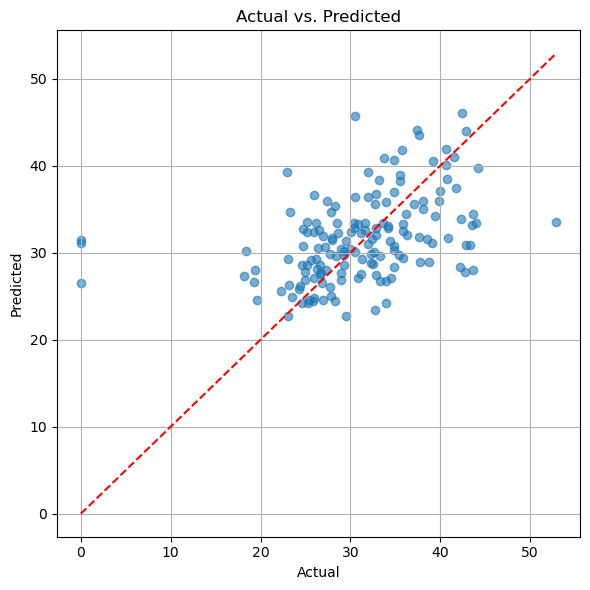

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()